# Text Classification with **MUSE Embeddings** and ***Bi-LSTM Network*** Keras
En este notebook se descargan los muse embeddings y se implementa el modelo biLSTM para la clasificación de texto con su consecuente evaluación en otros idiomas.

Se realizan 2 pruebas: 
1. Entrenamiento y evaluación del modelo con dato en inglés y posterior TEST con dato en otros idiomas (Zero-Shot básico)
2. Entrenamiento con dato en ingles + idioma objetivo ( añadidos 1000 ejemplos del idioma objetivo para el entrenamiento), evaluación en inglés y TEST sobre el idioma objetivo. (Few-Shot)


# Librerias

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(0)
import io
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
%%capture
!pip install keras
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import os
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import RMSprop, SGD, Adam, Nadam


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Need
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
%%capture
!pip install wandb 
import wandb
from wandb.keras import WandbCallback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga Muse Embeddings English

In [ ]:
def read_muse_vecs(muse_file):
        with open(muse_file, 'r',  errors='ignore', encoding="utf-8") as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word_list = line[0: len(line) - 300]
                curr_word = ""
                for t in curr_word_list:
                    curr_word = curr_word + str(t) + " "
                curr_word = curr_word.strip()
                words.add(curr_word)
                try:
                    word_to_vec_map[curr_word] = np.array(line[-300:], dtype=np.float64)
                except:
                    print(line, len(line))

            i = 1
            words_to_index = {}
            index_to_words = {}

            words.add("nokey")
            word_to_vec_map["nokey"] = np.zeros((300,), dtype=np.float64)

            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [ ]:
%%capture
Pathjup = "muse/data/wiki.en.vec"
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.multi.en.vec"

words_to_index, index_to_words, word_to_vec_map = read_muse_vecs(Pathdrive)

In [ ]:
## Diccionario con word-embeddings(300)
%%capture
word_to_vec_map.keys()

In [ ]:
# Tamaño del vocabulario de ingles
len(words_to_index)

199989

In [ ]:
# Embeddings palabra "no"
len(word_to_vec_map["no"]) 

300

####Visualize MUSE

In [ ]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [ ]:
src_path = "/content/drive/MyDrive/muse/data/wiki.multi.en.vec"
tgt_path = "/content/drive/MyDrive/muse/data/wiki.multi.de.vec"
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

In [ ]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [ ]:
# printing nearest neighbors in the source space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [ ]:
# printing nearest neighbors in the target space
src_word = 'cat'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "cat":
0.6035 - katze
0.5583 - hund
0.5309 - cat
0.5161 - haustier
0.5131 - katzen


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.06


In [ ]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

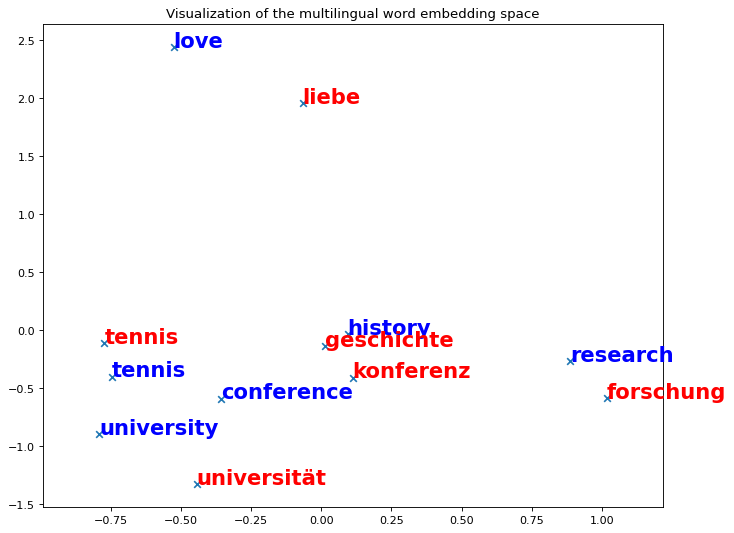

In [ ]:
# get 5 random input words
src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
#src_words = ['université', 'amour', 'histoire', 'tennis', 'rechercher', 'conférence']
tgt_words = ['universität', 'liebe', 'geschichte', u'tennis',  u'forschung', 'konferenz']
#tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)

# Carga del dato textual

## Load Amazon Dataset English

In [ ]:
path1 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv"
path2 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path3 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [ ]:
df_train = pd.read_csv(path1)
df_valid = pd.read_csv(path2)
df_test = pd.read_csv(path3)

In [ ]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17


## Load FEW-ONE Shot Training Dataset

In [ ]:
path11 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/few_shot/few_shot_ES.csv" ## incluye 1000 ejemplos en español dentro del training data
path22 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [ ]:
df_train = pd.read_csv(path11)
df_valid = pd.read_csv(path22)
df_test = pd.read_csv(path33)

In [ ]:
df_train.head(-10)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17
1,en_0612910,product_en_0295449,reviewer_en_0312138,1,"The leg openings are a little small, but other...",Crap,en,apparel,"Crap The leg openings are a little small, but ...","Crap The leg openings are a little small, but ...","The leg openings are a little small, but other...",0
2,en_0983065,product_en_0295095,reviewer_en_0927618,3,Really cute mug. I would have given 5 stars if...,Four Stars,en,kitchen,Four Stars Really cute mug. I would have given...,Four Stars Really cute mug. I would have given...,Really cute mug. I would have given 5 stars if...,16
3,en_0206761,product_en_0563487,reviewer_en_0936741,1,Well it’s looks and feels okay but it most cer...,Lies!!,en,industrial_supplies,Lies!! Well it’s looks and feels okay but it m...,Lies!! Well it’s looks and feels okay but it m...,Well it’s looks and feels okay but it most cer...,14
4,en_0510474,product_en_0704805,reviewer_en_0417600,0,"Very, very thin, you can bend them with you fi...",Thin and bendable :(,en,pet_products,"Thin and bendable :( Very, very thin, you can ...","Thin and bendable :( Very, very thin, you can ...","Very, very thin, you can bend them with you fi...",24
...,...,...,...,...,...,...,...,...,...,...,...,...
200985,es_0210704,product_es_0624579,reviewer_es_0666394,3,"Bastante bueno, se acopla bien.",La movilidad,es,sports,"La movilidad Bastante bueno, se acopla bien.","La movilidad Bastante bueno, se acopla bien. s...","Bastante bueno, se acopla bien. sports",25
200986,es_0197898,product_es_0236309,reviewer_es_0227148,3,Justo lo que esperaba. Lo quería para mi hija ...,Muy buena compra,es,book,Muy buena compra Justo lo que esperaba. Lo que...,Muy buena compra Justo lo que esperaba. Lo que...,Justo lo que esperaba. Lo quería para mi hija ...,4
200987,es_0458856,product_es_0988450,reviewer_es_0225536,1,Se escuchan muy bien pero tienen un problema g...,Mal diseñados,es,wireless,Mal diseñados Se escuchan muy bien pero tienen...,Mal diseñados Se escuchan muy bien pero tienen...,Se escuchan muy bien pero tienen un problema g...,29
200988,es_0096701,product_es_0054928,reviewer_es_0976333,2,"Las instrucciones no estan bien detalladas, pe...",Mansión Gatuna,es,pet_products,Mansión Gatuna Las instrucciones no estan bien...,Mansión Gatuna Las instrucciones no estan bien...,"Las instrucciones no estan bien detalladas, pe...",23


# Pre - procesado del dato textual

In [ ]:
## Función para tokenizar, codificar y realizar el padding sobre las reviews 

def preprocess(X_train,X_val,X_test,y_train,y_val,y_test):
 
  ## Tokenize reviews
  X_data_full = pd.concat([X_train, X_val, X_test],ignore_index=True)
  t= Tokenizer()
  t.fit_on_texts(X_data_full)
  vocab_size = len(t.word_index)+1
  max_length = 260

  # Cod and pad reviews
  encoded_rev = t.texts_to_sequences(X_train)
  padded_rev = pad_sequences(encoded_rev,maxlen=max_length,padding= 'post')

  encoded_rev_val = t.texts_to_sequences(X_val)
  padded_rev_val = pad_sequences(encoded_rev_val,maxlen=max_length,padding= 'post')

  encoded_rev_test = t.texts_to_sequences(X_test)
  padded_rev_test = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')

  return t, vocab_size, padded_rev, padded_rev_val, padded_rev_test

# Modelos de clasificación

## Rating Classification 

In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

#X_train = df_train['text_title']
#X_val= df_valid['text_title']
#X_test= df_test['text_title']

#X_train = df_train['text_title_cat']
#X_val= df_valid['text_title_cat']
#X_test= df_test['text_title_cat']



y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

# Aplicamos pre-procesado 
t,vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
# Creamos matriz de embeddings a partir del vocab de las review_body y los embeddings MUSE,  FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(47071, 300)

In [ ]:
# Initialize wandb with your project name 
run = wandb.init(project='MUSE',
                 group = 'Rating classification', #para agrupar los runs dentro del frontend
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 64,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "BiLSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment

In [ ]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import GlobalMaxPool1D
from keras.layers import GRU
#from attention import Attention

# MODEL ARCHITECTURE
modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
modelbi.add(GlobalMaxPool1D())
modelbi.add(Dropout(0.4))
modelbi.add(Dense(1000,activation='relu'))
modelbi.add(Dense(5,activation='softmax'))

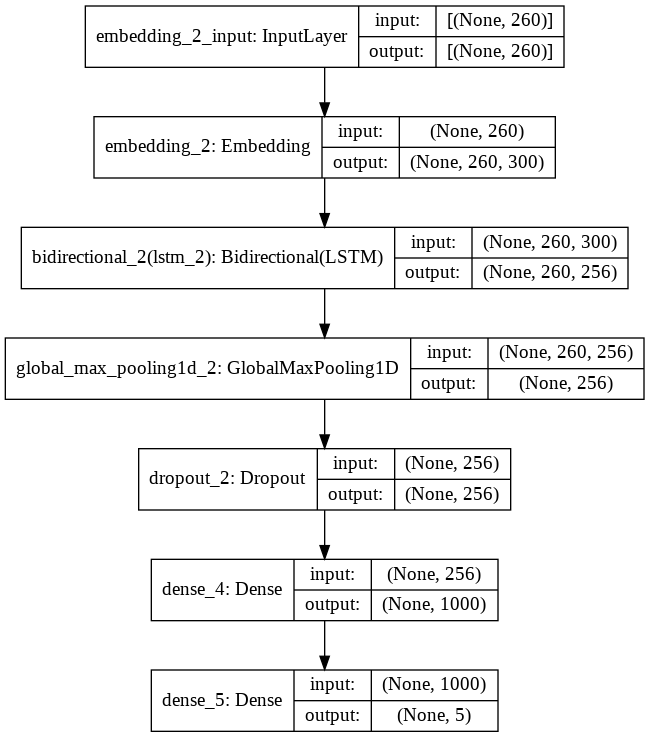

In [ ]:
from keras.utils import plot_model
plot_model(modelbi, '/content/drive/MyDrive/TFG/model_arq/MUSE.png', show_shapes=True)

In [ ]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer=Adam(lr=config.learning_rate), metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 260, 300)          14604300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260, 256)          439296    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              257000    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 5005      
Total params: 15,305,601
Trainable params: 701,301
Non-trainable params: 14,604,300
____________________________________

In [ ]:
## Model with Learning Rate Scheduler 

#1st approach (Time based (ya implementado por keras en los optimizadores))
decay_rate = config.learning_rate / config.epochs
momentum = 0.8
modelbi.compile(loss=config.loss_function, optimizer=Adam(lr=config.learning_rate, decay=decay_rate), metrics=['accuracy'])

In [ ]:
#2nd approach (Drop based Learning Rate) systematically drop the learning rate at specific times during training.
# Utilizamos un callback llamado LearningRate Scheduler y lo introducimos en el model fit. Mediante la función step_decay definimos como queremos que se realice esa logica de descenso

from keras.callbacks import LearningRateScheduler
import math
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.05
	epochs_drop = 2.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# callback a introducir en fit
lrate = LearningRateScheduler(step_decay)

modelbi.compile(loss=config.loss_function, optimizer=Adam(lr=0.0), metrics=['accuracy'])


In [ ]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback(),lrate])

wandb.finish()

Epoch 1/5
3125/3125 [==============================] - 119s 37ms/step - loss: 1.2671 - accuracy: 0.4380 - val_loss: 1.0728 - val_accuracy: 0.5152
Epoch 2/5
3125/3125 [==============================] - 115s 37ms/step - loss: 1.0705 - accuracy: 0.5320 - val_loss: 1.0682 - val_accuracy: 0.5216
Epoch 3/5
3125/3125 [==============================] - 115s 37ms/step - loss: 1.0602 - accuracy: 0.5357 - val_loss: 1.0662 - val_accuracy: 0.5240
Epoch 4/5
3125/3125 [==============================] - 114s 37ms/step - loss: 1.0631 - accuracy: 0.5328 - val_loss: 1.0662 - val_accuracy: 0.5232
Epoch 5/5
3125/3125 [==============================] - 115s 37ms/step - loss: 1.0608 - accuracy: 0.5359 - val_loss: 1.0662 - val_accuracy: 0.5236


epoch,4
loss,1.06124
accuracy,0.53566
val_loss,1.06617
val_accuracy,0.5236
_runtime,627
_timestamp,1617274798
_step,4
best_val_loss,1.06617
best_epoch,4


epoch,▁▃▅▆█
loss,█▂▁▁▁
accuracy,▁████
val_loss,█▃▁▁▁
val_accuracy,▁▆█▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


In [ ]:
#SAVE MODEL AND LOAD TO TEST

In [ ]:
modelbi.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Rating_text.h5')

In [ ]:
model_rating_body = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Rating_text.h5')

In [ ]:
loss,acc = model_rating_body.evaluate(x=padded_rev_test, y=y_test, batch_size=64, verbose=1)

## Category Classification

In [ ]:
#X_train = df_train['review_body']
#X_val= df_valid['review_body']
#X_test= df_test['review_body']

X_train = df_train['text_title']
X_val= df_valid['text_title']
X_test= df_test['text_title']



y_train = df_train['product_category_cod']
y_val = df_valid['product_category_cod']
y_test= df_test['product_category_cod']


# Aplicamos pre-procesado 
t,vocab_size, padded_rev, padded_rev_val, padded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)


In [ ]:
#Creamos matriz de embeddings a partir del vocab de las text_title_cat FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# Initialize wandb with your project name 
run = wandb.init(project='MUSE',
                 group = 'Category classification', #para agrupar los runs dentro del frontend
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 64,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "BiLSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment

In [ ]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional

# MODEL ARCHITECTURE
modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
modelbi.add(GlobalMaxPool1D())
modelbi.add(Dropout(0.4))
modelbi.add(Dense(1000,activation='relu'))
modelbi.add(Dense(31,activation='softmax'))

In [ ]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 260, 300)          14604300  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 260, 256)          439296    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              257000    
_________________________________________________________________
dense_11 (Dense)             (None, 31)                31031     
Total params: 15,331,627
Trainable params: 727,327
Non-trainable params: 14,604,300
____________________________________

In [ ]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])
wandb.finish()

Epoch 1/5
3125/3125 [==============================] - 120s 38ms/step - loss: 2.4789 - accuracy: 0.2894 - val_loss: 1.9254 - val_accuracy: 0.4440
Epoch 2/5
3125/3125 [==============================] - 118s 38ms/step - loss: 1.9166 - accuracy: 0.4486 - val_loss: 1.8265 - val_accuracy: 0.4696
Epoch 3/5
3125/3125 [==============================] - 117s 37ms/step - loss: 1.8296 - accuracy: 0.4739 - val_loss: 1.7746 - val_accuracy: 0.4756
Epoch 4/5
3125/3125 [==============================] - 117s 37ms/step - loss: 1.7778 - accuracy: 0.4866 - val_loss: 1.7405 - val_accuracy: 0.4912
Epoch 5/5
3125/3125 [==============================] - 118s 38ms/step - loss: 1.7433 - accuracy: 0.4951 - val_loss: 1.7235 - val_accuracy: 0.4960


epoch,4
loss,1.7444
accuracy,0.49476
val_loss,1.72348
val_accuracy,0.496
_runtime,593
_timestamp,1617191183
_step,4
best_val_loss,1.72348
best_epoch,4


epoch,▁▃▅▆█
loss,█▃▂▁▁
accuracy,▁▆▇██
val_loss,█▅▃▂▁
val_accuracy,▁▄▅▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


In [ ]:
#Guardamos el modelo
modelbi.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text.h5')

In [ ]:
model_cat_body = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text.h5')

In [ ]:
loss,acc = model_cat_body.evaluate(x=padded_rev_test, y=y_test, batch_size=64, verbose=1)

# Carga de modelos entrenados

In [ ]:
# Monolingual INGLES 

# Rating classification review_body
model_rating_body = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Rating_text.h5')

# Rating classification review_body + title 
model_rating_body_title = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Rating_text_title.h5')

# Rating classification review_body + title + cat
model_rating_body_title_cat = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Rating_text_title_cat.h5')

# Category classification review_body
model_cat_body = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text.h5')

# Category classification review_body + title
model_cat_body_title = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text_title.h5')


In [ ]:
# Few Shot ESpañol
model_rating_body_fewshotes = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Rating_text_few_shotES.h5')
model_rating_body_title_fewshotes = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Rating_text_title_few_shotES.h5')
model_rating_body_title_cat_fewshotes = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Rating_text_title_cat_few_shotES.h5')
model_cat_body_fewshotes = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Category_text_few_shotES.h5')
model_cat_body_title_fewshotes = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Category_text_title_few_shotES.h5')

# One Shot Español


In [ ]:
#Few Shot Frances

#One Shot Franes

In [ ]:
#Few Shot aleman 

#One Shot aleman


# Test del modelo con dato en idioma de entrenamiento (Inglés)

In [ ]:
## Función evaluación dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def eval_model(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                            y=test_labels, 
                            batch_size=64, 
                            verbose=1)
  
  
  predictions = model.predict(test_data)
  matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
  plt.figure(figsize = (10,7))
  
  ## Confusion matrix with counts
  sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

  ## Confusion matrix with percentages
  #sns.heatmap(matrix/np.sum(matrix), annot=True, 
              #fmt='.2%', cmap='Purples')

  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions.argmax(axis=1))

  return print(clas_report)

40/40 [==============================] - 1s 22ms/step - loss: 1.0111 - accuracy: 0.5548
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       480
           1       0.46      0.55      0.50       530
           2       0.45      0.38      0.41       501
           3       0.52      0.49      0.50       479
           4       0.71      0.73      0.72       510

    accuracy                           0.55      2500
   macro avg       0.56      0.55      0.55      2500
weighted avg       0.55      0.55      0.55      2500



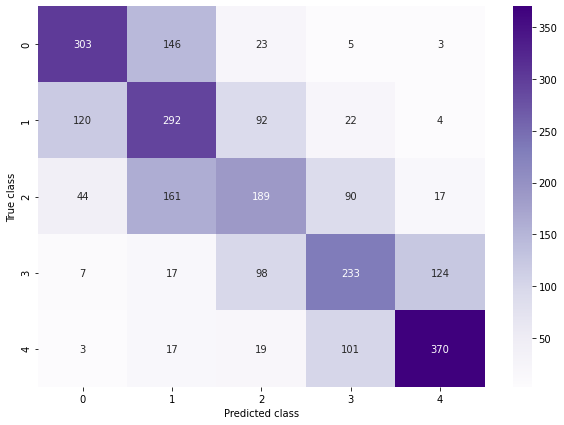

In [ ]:
## CUIDADO CON EL DATO DE TEST QUE METES, DISTINTO PARA CADA MODELO
eval_model(model_rating_body,padded_rev_test,y_test)

# Test del modelo con dato en otros idiomas

### Test sobre dato Español

In [ ]:
# MUSE embeddings Español
%%capture
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.multi.es.vec"
words_to_index_es, index_to_words_es, word_to_vec_map_es = read_muse_vecs(Pathdrive)

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonES_test.csv"
df_test_es = pd.read_csv(path33)

In [ ]:
X_test_es = df_test_es['review_body']
#_test_es = df_test_es['text_title']
#X_test_es = df_test_es['text_title_cat']

Y_test_es = df_test_es['star_rating']
#Y_test_es = df_test_es['product_category_cod']

In [ ]:
t3= Tokenizer()
t3.fit_on_texts(X_test_es)
vocab_size = len(t3.word_index)+1
encoded_rev_test = t3.texts_to_sequences(X_test_es)
max_length = 260
padded_rev_test_es = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')


In [ ]:
## Función evaluación dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def eval_spanish(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                                        y=test_labels, 
                                        batch_size=64, 
                                        verbose=1)
  
  
  predictions = model.predict(test_data)
  matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
  plt.figure(figsize = (10,7))
  ## Confusion matrix with counts
  sns.heatmap(matrix, annot=True,cmap='Oranges',fmt='g')

  #sns.heatmap(matrix/np.sum(matrix), annot=True, 
   #          fmt='.2%', cmap='Oranges')
  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions.argmax(axis=1))

  return print(clas_report)

40/40 [==============================] - 1s 21ms/step - loss: 2.1136 - accuracy: 0.2064
              precision    recall  f1-score   support

           0       0.19      0.08      0.11       498
           1       0.22      0.31      0.26       497
           2       0.20      0.32      0.25       503
           3       0.21      0.20      0.20       497
           4       0.18      0.13      0.15       505

    accuracy                           0.21      2500
   macro avg       0.20      0.21      0.19      2500
weighted avg       0.20      0.21      0.19      2500



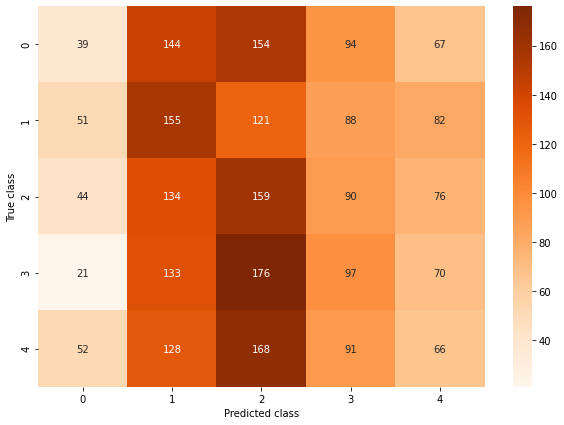

In [ ]:
eval_spanish(model_rating_body,padded_rev_test_es,Y_test_es)

### Test sobre dato Frances

In [ ]:
# MUSE embeddings Español
%%capture
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.multi.fr.vec"
words_to_index_fr, index_to_words_fr, word_to_vec_map_fr = read_muse_vecs(Pathdrive)

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonFR_test.csv"
df_test_fr = pd.read_csv(path33)

In [ ]:
X_test_fr = df_test_fr['review_body']
Y_test_fr = df_test_fr['star_rating']

In [ ]:
t3= Tokenizer()
t3.fit_on_texts(X_test_fr)
vocab_size = len(t3.word_index)+1
encoded_rev_test = t3.texts_to_sequences(X_test_fr)
max_length = 260
padded_rev_test_fr = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')


In [ ]:
## Función evaluación dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
def eval_french(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                                        y=test_labels, 
                                        batch_size=64, 
                                        verbose=1)
  
  
  predictions = model.predict(test_data)
  matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
  plt.figure(figsize = (10,7))
  ## Confusion matrix with counts
  #sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

  sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Greens')
  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions.argmax(axis=1))

  return print(clas_report)

40/40 [==============================] - 1s 20ms/step - loss: 4.5900 - accuracy: 0.0448


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.21      0.12      0.15       497
           1       0.14      0.02      0.04       510
           2       0.27      0.01      0.02       507
           3       0.21      0.06      0.09       488
           4       0.16      0.02      0.03       498
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00    

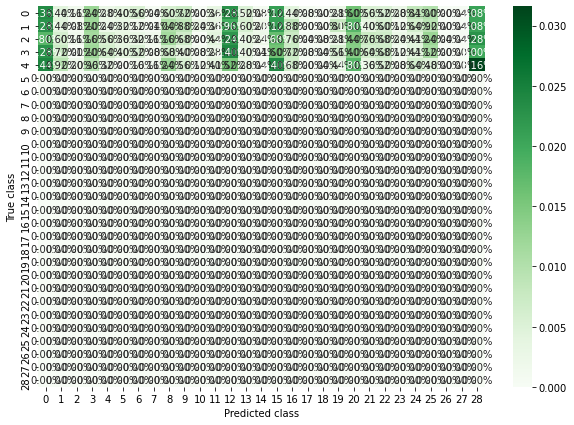

In [ ]:
eval_french(model_cat_body, padded_rev_test_fr,Y_test_fr)

### Test sobre dato Aleman

In [ ]:
# MUSE embeddings Español
%%capture
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.multi.de.vec"
words_to_index_es, index_to_words_es, word_to_vec_map_es = read_muse_vecs(Pathdrive)

In [ ]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonDE_test.csv"
df_test_de = pd.read_csv(path33)

In [ ]:
X_test_de = df_test_de['review_body']
Y_test_de = df_test_de['star_rating']

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t3= Tokenizer()
t3.fit_on_texts(X_test_de)
vocab_size = len(t3.word_index)+1
encoded_rev_test = t3.texts_to_sequences(X_test_de)
max_length = 260
padded_rev_test_de = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')


In [ ]:
## Función evaluación dato  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def eval_german(model,test_data,test_labels):

  """
  Recibe el modelo, el dato de test ya procesado (x idioma) y las true labels
  """
  loss,acc = model.evaluate(x=test_data, 
                                        y=test_labels, 
                                        batch_size=64, 
                                        verbose=1)
  
  
  predictions = model.predict(test_data)
  matrix = confusion_matrix(test_labels, predictions.argmax(axis=1))
  plt.figure(figsize = (30,10))
   ## Confusion matrix with counts
  #sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')
  sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Greys')
  plt.xlabel("Predicted class")
  plt.ylabel("True class") 

  clas_report = classification_report(test_labels, predictions.argmax(axis=1))

  return print(clas_report)

40/40 [==============================] - 1s 20ms/step - loss: 4.8126 - accuracy: 0.0484


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.20      0.07      0.10       521
           1       0.20      0.03      0.05       487
           2       0.27      0.01      0.03       488
           3       0.22      0.12      0.16       507
           4       0.10      0.01      0.01       497
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00    

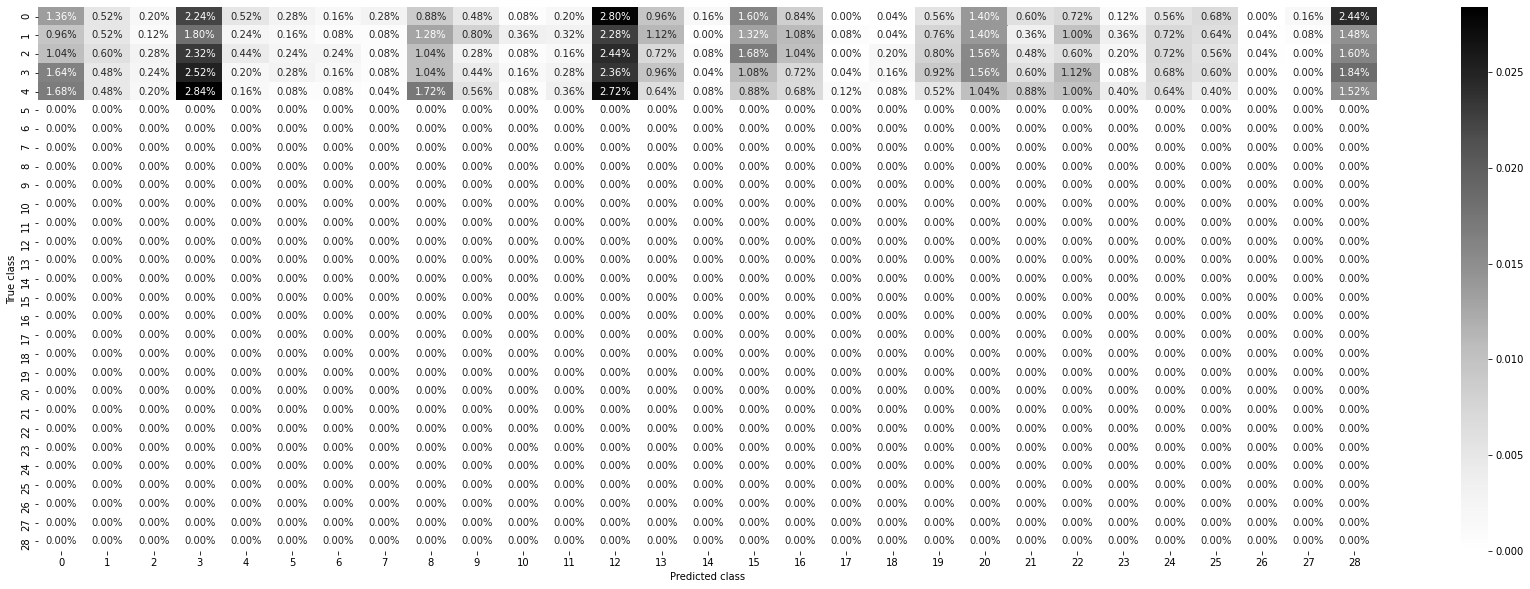

In [ ]:
eval_german(model_cat_body_title, padded_rev_test_de,Y_test_de)

# Sweep PARAMETROS 

#### Sweep bilstm 

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,8]
        },
        'batch_size': {
            'values': [128, 64]
        },
        'dropout': {
            'values': [0.3, 0.4]
        },

        'learning_rate': {
            'values': [ 1e-3,3e-3, 3e-4,1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['softmax']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

Create sweep with ID: gkevt11s
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/gkevt11s


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GlobalMaxPool1D
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'activation': 'softmax',
        'optimizer': 'adam',
        'dropout': 0.4,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    modelbi = Sequential()
    embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
    modelbi.add(embed)
    modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
    modelbi.add(GlobalMaxPool1D())
    modelbi.add(Dropout(0.4))
    modelbi.add(Dense(1000,activation='relu'))
    modelbi.add(Dense(31,activation='softmax'))

    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    modelbi.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    modelbi.fit(padded_rev, y_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(padded_rev_val, y_val),
              callbacks=[WandbCallback(validation_data=(padded_rev_val, y_val))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: f4jg9bd6 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 131s 62ms/step - loss: 2.6088 - accuracy: 0.2529 - val_loss: 1.9999 - val_accuracy: 0.4232
Epoch 2/5
1563/1563 [==============================] - 96s 61ms/step - loss: 2.0063 - accuracy: 0.4237 - val_loss: 1.8877 - val_accuracy: 0.4520
Epoch 3/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.9069 - accuracy: 0.4483 - val_loss: 1.8317 - val_accuracy: 0.4640
Epoch 4/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.8499 - accuracy: 0.4671 - val_loss: 1.8062 - val_accuracy: 0.4676
Epoch 5/5
1563/1563 [==============================] - 96s 61ms/step - loss: 1.8164 - accuracy: 0.4744 - val_loss: 1.7818 - val_accuracy: 0.4728


epoch,4
loss,1.81247
accuracy,0.47542
val_loss,1.78178
val_accuracy,0.4728
_runtime,517
_timestamp,1616672347
_step,4
best_val_loss,1.78178
best_epoch,4


epoch,▁▃▅▆█
loss,█▃▂▁▁
accuracy,▁▆▇██
val_loss,█▄▃▂▁
val_accuracy,▁▅▇▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 714vje6f with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 101s 63ms/step - loss: 2.4209 - accuracy: 0.3054 - val_loss: 1.8865 - val_accuracy: 0.4584
Epoch 2/5
1563/1563 [==============================] - 96s 62ms/step - loss: 1.9244 - accuracy: 0.4481 - val_loss: 1.8217 - val_accuracy: 0.4696
Epoch 3/5
1563/1563 [==============================] - 96s 61ms/step - loss: 1.8460 - accuracy: 0.4676 - val_loss: 1.8006 - val_accuracy: 0.4716
Epoch 4/5
1563/1563 [==============================] - 97s 62ms/step - loss: 1.8081 - accuracy: 0.4748 - val_loss: 1.7714 - val_accuracy: 0.4876
Epoch 5/5
1563/1563 [==============================] - 97s 62ms/step - loss: 1.7622 - accuracy: 0.4887 - val_loss: 1.7484 - val_accuracy: 0.4972


epoch,4
loss,1.77237
accuracy,0.48633
val_loss,1.74842
val_accuracy,0.4972
_runtime,491
_timestamp,1616672845
_step,4
best_val_loss,1.74842
best_epoch,4


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▆▇▇█
val_loss,█▅▄▂▁
val_accuracy,▁▃▃▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 09khtbp8 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 8
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/8
3125/3125 [==============================] - 127s 40ms/step - loss: 2.5052 - accuracy: 0.2825 - val_loss: 1.9345 - val_accuracy: 0.4416
Epoch 2/8
3125/3125 [==============================] - 124s 40ms/step - loss: 1.9568 - accuracy: 0.4373 - val_loss: 1.8546 - val_accuracy: 0.4588
Epoch 3/8
3125/3125 [==============================] - 123s 40ms/step - loss: 1.8698 - accuracy: 0.4587 - val_loss: 1.7970 - val_accuracy: 0.4732
Epoch 4/8
3125/3125 [==============================] - 123s 39ms/step - loss: 1.8172 - accuracy: 0.4731 - val_loss: 1.7840 - val_accuracy: 0.4840
Epoch 5/8
3125/3125 [==============================] - 123s 39ms/step - loss: 1.7807 - accuracy: 0.4831 - val_loss: 1.7733 - val_accuracy: 0.4876
Epoch 6/8
3125/3125 [==============================] - 123s 39ms/step - loss: 1.7556 - accuracy: 0.4896 - val_loss: 1.7575 - val_accuracy: 0.4968
Epoch 7/8
3125/3125 [==============================] - 123s 39ms/step - loss: 1.7329 - accuracy: 0.4966 - val_loss: 1.7445 -

epoch,7
loss,1.71778
accuracy,0.49854
val_loss,1.73745
val_accuracy,0.4964
_runtime,994
_timestamp,1616673846
_step,7
best_val_loss,1.73745
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▂▂▂▁▁
accuracy,▁▅▆▇▇▇██
val_loss,█▅▃▃▂▂▁▁
val_accuracy,▁▃▅▆▇█▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: a9qjjpbf with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 103s 64ms/step - loss: 2.4156 - accuracy: 0.3069 - val_loss: 1.8771 - val_accuracy: 0.4624
Epoch 2/5
1563/1563 [==============================] - 99s 63ms/step - loss: 1.9181 - accuracy: 0.4474 - val_loss: 1.8403 - val_accuracy: 0.4640
Epoch 3/5
1563/1563 [==============================] - 99s 64ms/step - loss: 1.8462 - accuracy: 0.4660 - val_loss: 1.8002 - val_accuracy: 0.4756
Epoch 4/5
1563/1563 [==============================] - 98s 63ms/step - loss: 1.8042 - accuracy: 0.4771 - val_loss: 1.7871 - val_accuracy: 0.4940
Epoch 5/5
1563/1563 [==============================] - 99s 63ms/step - loss: 1.7718 - accuracy: 0.4847 - val_loss: 1.7567 - val_accuracy: 0.4944


epoch,4
loss,1.77782
accuracy,0.48382
val_loss,1.75668
val_accuracy,0.4944
_runtime,502
_timestamp,1616674356
_step,4
best_val_loss,1.75668
best_epoch,4


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▆▇██
val_loss,█▆▄▃▁
val_accuracy,▁▁▄██
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 0ehlfvcd with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 126s 39ms/step - loss: 2.3695 - accuracy: 0.3199 - val_loss: 1.8809 - val_accuracy: 0.4636
Epoch 2/5
3125/3125 [==============================] - 122s 39ms/step - loss: 1.9188 - accuracy: 0.4482 - val_loss: 1.8133 - val_accuracy: 0.4748
Epoch 3/5
3125/3125 [==============================] - 122s 39ms/step - loss: 1.8492 - accuracy: 0.4662 - val_loss: 1.7921 - val_accuracy: 0.4784
Epoch 4/5
3125/3125 [==============================] - 122s 39ms/step - loss: 1.8096 - accuracy: 0.4750 - val_loss: 1.7610 - val_accuracy: 0.4916
Epoch 5/5
3125/3125 [==============================] - 123s 39ms/step - loss: 1.7636 - accuracy: 0.4863 - val_loss: 1.7497 - val_accuracy: 0.4948


epoch,4
loss,1.77753
accuracy,0.48298
val_loss,1.7497
val_accuracy,0.4948
_runtime,619
_timestamp,1616674984
_step,4
best_val_loss,1.7497
best_epoch,4


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▆▇▇█
val_loss,█▄▃▂▁
val_accuracy,▁▄▄▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: zfo1426j with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
3125/3125 [==============================] - 128s 40ms/step - loss: 3.2603 - accuracy: 0.0835 - val_loss: 3.1589 - val_accuracy: 0.0932
Epoch 2/8
3125/3125 [==============================] - 124s 40ms/step - loss: 3.1294 - accuracy: 0.1049 - val_loss: 3.0107 - val_accuracy: 0.1408
Epoch 3/8
3125/3125 [==============================] - 125s 40ms/step - loss: 2.9750 - accuracy: 0.1573 - val_loss: 2.8935 - val_accuracy: 0.1684
Epoch 4/8
3125/3125 [==============================] - 124s 40ms/step - loss: 2.8898 - accuracy: 0.1753 - val_loss: 2.8073 - val_accuracy: 0.1912
Epoch 5/8
3125/3125 [==============================] - 124s 40ms/step - loss: 2.8100 - accuracy: 0.1957 - val_loss: 2.7333 - val_accuracy: 0.2148
Epoch 6/8
3125/3125 [==============================] - 124s 40ms/step - loss: 2.7562 - accuracy: 0.2061 - val_loss: 2.6888 - val_accuracy: 0.2296
Epoch 7/8
3125/3125 [==============================] - 124s 40ms/step - loss: 2.7149 - accuracy: 0.2140 - val_loss: 2.6562 -

epoch,7
loss,2.67938
accuracy,0.22471
val_loss,2.61949
val_accuracy,0.2404
_runtime,1001
_timestamp,1616675994
_step,7
best_val_loss,2.61949
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▇▅▄▃▂▁▁
accuracy,▁▃▅▆▇▇██
val_loss,█▆▅▃▂▂▁▁
val_accuracy,▁▃▅▆▇▇▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: q2lcvmmp with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.003
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 127s 40ms/step - loss: 2.3544 - accuracy: 0.3258 - val_loss: 1.8830 - val_accuracy: 0.4560
Epoch 2/5
3125/3125 [==============================] - 125s 40ms/step - loss: 1.9223 - accuracy: 0.4478 - val_loss: 1.8209 - val_accuracy: 0.4708
Epoch 3/5
3125/3125 [==============================] - 125s 40ms/step - loss: 1.8453 - accuracy: 0.4665 - val_loss: 1.7900 - val_accuracy: 0.4776
Epoch 4/5
3125/3125 [==============================] - 125s 40ms/step - loss: 1.8068 - accuracy: 0.4749 - val_loss: 1.7738 - val_accuracy: 0.4884
Epoch 5/5
3125/3125 [==============================] - 125s 40ms/step - loss: 1.7715 - accuracy: 0.4860 - val_loss: 1.7767 - val_accuracy: 0.4884


epoch,4
loss,1.77842
accuracy,0.48364
val_loss,1.77669
val_accuracy,0.4884
_runtime,630
_timestamp,1616676633
_step,4
best_val_loss,1.77379
best_epoch,3


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▆▇▇█
val_loss,█▄▂▁▁
val_accuracy,▁▄▆██
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: l36yt8jw with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 104s 65ms/step - loss: 2.8842 - accuracy: 0.1744 - val_loss: 2.3274 - val_accuracy: 0.3236
Epoch 2/8
1563/1563 [==============================] - 101s 64ms/step - loss: 2.3142 - accuracy: 0.3300 - val_loss: 2.1299 - val_accuracy: 0.3900
Epoch 3/8
1563/1563 [==============================] - 100s 64ms/step - loss: 2.1658 - accuracy: 0.3752 - val_loss: 2.0480 - val_accuracy: 0.4092
Epoch 4/8
1563/1563 [==============================] - 100s 64ms/step - loss: 2.0855 - accuracy: 0.3981 - val_loss: 1.9884 - val_accuracy: 0.4196
Epoch 5/8
1563/1563 [==============================] - 101s 65ms/step - loss: 2.0235 - accuracy: 0.4147 - val_loss: 1.9514 - val_accuracy: 0.4316
Epoch 6/8
1563/1563 [==============================] - 101s 65ms/step - loss: 1.9822 - accuracy: 0.4261 - val_loss: 1.9297 - val_accuracy: 0.4412
Epoch 7/8
1563/1563 [==============================] - 100s 64ms/step - loss: 1.9428 - accuracy: 0.4393 - val_loss: 1.9022 -

epoch,7
loss,1.91423
accuracy,0.44602
val_loss,1.8717
val_accuracy,0.4556
_runtime,812
_timestamp,1616677455
_step,7
best_val_loss,1.8717
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▃▂▂▁▁
accuracy,▁▄▆▇▇▇██
val_loss,█▅▄▃▂▂▁▁
val_accuracy,▁▅▆▆▇▇██
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: mnwqxpu3 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 105s 65ms/step - loss: 3.2986 - accuracy: 0.0783 - val_loss: 3.1712 - val_accuracy: 0.0928
Epoch 2/8
1563/1563 [==============================] - 100s 64ms/step - loss: 3.1558 - accuracy: 0.0916 - val_loss: 3.1351 - val_accuracy: 0.1152
Epoch 3/8
1563/1563 [==============================] - 100s 64ms/step - loss: 3.1149 - accuracy: 0.1107 - val_loss: 3.0859 - val_accuracy: 0.1300
Epoch 4/8
1563/1563 [==============================] - 101s 64ms/step - loss: 3.0563 - accuracy: 0.1338 - val_loss: 2.9777 - val_accuracy: 0.1520
Epoch 5/8
1563/1563 [==============================] - 101s 64ms/step - loss: 2.9702 - accuracy: 0.1592 - val_loss: 2.9045 - val_accuracy: 0.1688
Epoch 6/8
1563/1563 [==============================] - 100s 64ms/step - loss: 2.9068 - accuracy: 0.1727 - val_loss: 2.8440 - val_accuracy: 0.1812
Epoch 7/8
1563/1563 [==============================] - 100s 64ms/step - loss: 2.8485 - accuracy: 0.1862 - val_loss: 2.7920 -

epoch,7
loss,2.79508
accuracy,0.19749
val_loss,2.75322
val_accuracy,0.2112
_runtime,811
_timestamp,1616678275
_step,7
best_val_loss,2.75322
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▇▆▅▄▃▂▁
accuracy,▁▂▃▅▆▇▇█
val_loss,█▇▇▅▄▃▂▁
val_accuracy,▁▂▃▄▅▆▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: hqs4fqvx with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 128s 40ms/step - loss: 2.7788 - accuracy: 0.2014 - val_loss: 2.2097 - val_accuracy: 0.3632
Epoch 2/5
3125/3125 [==============================] - 124s 40ms/step - loss: 2.2045 - accuracy: 0.3647 - val_loss: 2.0580 - val_accuracy: 0.4068
Epoch 3/5
3125/3125 [==============================] - 124s 40ms/step - loss: 2.0686 - accuracy: 0.4045 - val_loss: 1.9537 - val_accuracy: 0.4340
Epoch 4/5
3125/3125 [==============================] - 124s 40ms/step - loss: 1.9917 - accuracy: 0.4244 - val_loss: 1.9177 - val_accuracy: 0.4396
Epoch 5/5
3125/3125 [==============================] - 124s 40ms/step - loss: 1.9294 - accuracy: 0.4425 - val_loss: 1.8848 - val_accuracy: 0.4556


epoch,4
loss,1.9314
accuracy,0.44172
val_loss,1.88478
val_accuracy,0.4556
_runtime,627
_timestamp,1616678911
_step,4
best_val_loss,1.88478
best_epoch,4


epoch,▁▃▅▆█
loss,█▄▂▂▁
accuracy,▁▅▇▇█
val_loss,█▅▂▂▁
val_accuracy,▁▄▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: k9wd6q46 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/8
3125/3125 [==============================] - 127s 40ms/step - loss: 2.7843 - accuracy: 0.2007 - val_loss: 2.2232 - val_accuracy: 0.3544
Epoch 2/8
3125/3125 [==============================] - 125s 40ms/step - loss: 2.2138 - accuracy: 0.3604 - val_loss: 2.0694 - val_accuracy: 0.4020
Epoch 3/8
3125/3125 [==============================] - 124s 40ms/step - loss: 2.0734 - accuracy: 0.4015 - val_loss: 1.9715 - val_accuracy: 0.4312
Epoch 4/8
3125/3125 [==============================] - 125s 40ms/step - loss: 1.9957 - accuracy: 0.4235 - val_loss: 1.9204 - val_accuracy: 0.4476
Epoch 5/8
3125/3125 [==============================] - 125s 40ms/step - loss: 1.9328 - accuracy: 0.4428 - val_loss: 1.8899 - val_accuracy: 0.4572
Epoch 6/8
3125/3125 [==============================] - 126s 40ms/step - loss: 1.8982 - accuracy: 0.4514 - val_loss: 1.8589 - val_accuracy: 0.4580
Epoch 7/8
3125/3125 [==============================] - 126s 40ms/step - loss: 1.8689 - accuracy: 0.4581 - val_loss: 1.8325 -

epoch,7
loss,1.84401
accuracy,0.46698
val_loss,1.81985
val_accuracy,0.4664
_runtime,1007
_timestamp,1616679929
_step,7
best_val_loss,1.81985
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▂▂▂▁▁
accuracy,▁▅▆▇▇▇██
val_loss,█▅▄▃▂▂▁▁
val_accuracy,▁▄▆▇▇▇██
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: 4uyrtttb with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 107s 66ms/step - loss: 3.3035 - accuracy: 0.0745 - val_loss: 3.1653 - val_accuracy: 0.0928
Epoch 2/8
1563/1563 [==============================] - 103s 66ms/step - loss: 3.1521 - accuracy: 0.0889 - val_loss: 3.1553 - val_accuracy: 0.0928
Epoch 3/8
1563/1563 [==============================] - 102s 65ms/step - loss: 3.1175 - accuracy: 0.1110 - val_loss: 2.9769 - val_accuracy: 0.1644
Epoch 4/8
1563/1563 [==============================] - 102s 65ms/step - loss: 2.9695 - accuracy: 0.1603 - val_loss: 2.8829 - val_accuracy: 0.1812
Epoch 5/8
1563/1563 [==============================] - 102s 65ms/step - loss: 2.8923 - accuracy: 0.1770 - val_loss: 2.8198 - val_accuracy: 0.1832
Epoch 6/8
1563/1563 [==============================] - 102s 65ms/step - loss: 2.8292 - accuracy: 0.1878 - val_loss: 2.7705 - val_accuracy: 0.1996
Epoch 7/8
1563/1563 [==============================] - 102s 65ms/step - loss: 2.7759 - accuracy: 0.1989 - val_loss: 2.7198 -

epoch,7
loss,2.72795
accuracy,0.20997
val_loss,2.68574
val_accuracy,0.2184
_runtime,826
_timestamp,1616680766
_step,7
best_val_loss,2.68574
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▇▆▄▃▂▂▁
accuracy,▁▁▄▆▆▇██
val_loss,██▅▄▃▂▁▁
val_accuracy,▁▁▅▆▆▇▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: rlj7cusa with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
2169/3125 [===================>..........] - ETA: 38s - loss: 3.2939 - accuracy: 0.0822

#PRUEBA DE LOS DISTINTAS ARQUITECTURAS PARA VER CUAL ES LA MÁS IDONEA


In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

# Aplicamos pre-procesado 
vocab_size, encoded_rev, encoded_rev_val, encoded_rev_test = preprocess(X_train,X_val,X_test,y_train,y_val,y_test)

In [ ]:
#Creamos matriz de embeddings a partir del vocab de las text_title_cat FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='MUSE_nn_arquitecture',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 64,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "BiGRU"
                 })
config = wandb.config  # We'll use this to configure our experiment


epoch,4
loss,0.9819
accuracy,0.56771
val_loss,1.00054
val_accuracy,0.564
_runtime,315
_timestamp,1616583820
_step,4
best_val_loss,1.00054
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▃▄▇█
val_loss,▄█▄▇▁
val_accuracy,▇▁▅▅█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


### Modelo

### Clasificador simple

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 260, 300)          14121300  
_________________________________________________________________
flatten_1 (Flatten)          (None, 78000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               19968256  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 34,090,841
Trainable params: 19,969,541
Non-trainable params: 14,121,300
_________________________________________________________________


In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3422 - accuracy: 0.4058 - val_loss: 1.2494 - val_accuracy: 0.4404
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1487 - accuracy: 0.5028 - val_loss: 1.2258 - val_accuracy: 0.4588
Epoch 3/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.0303 - accuracy: 0.5602 - val_loss: 1.2888 - val_accuracy: 0.4532
Epoch 4/5
3125/3125 [==============================] - 30s 10ms/step - loss: 0.8815 - accuracy: 0.6354 - val_loss: 1.3871 - val_accuracy: 0.4424
Epoch 5/5
3125/3125 [==============================] - 30s 10ms/step - loss: 0.7171 - accuracy: 0.7145 - val_loss: 1.6265 - val_accuracy: 0.4236


###  LSTMs

In [ ]:
#Modelo baseline
from keras.layers import LSTM
from keras.layers import GlobalMaxPool1D
from keras.models import Sequential

model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(LSTM(128,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(1000,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 260, 300)          14121300  
_________________________________________________________________
lstm_9 (LSTM)                (None, 260, 128)          219648    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 5005      
Total params: 14,474,953
Trainable params: 353,653
Non-trainable params: 14,121,300
___________________________________

In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
3125/3125 [==============================] - 65s 21ms/step - loss: 1.2592 - accuracy: 0.4424 - val_loss: 1.0832 - val_accuracy: 0.5244
Epoch 2/5
3125/3125 [==============================] - 64s 20ms/step - loss: 1.0988 - accuracy: 0.5169 - val_loss: 1.0911 - val_accuracy: 0.5284
Epoch 3/5
3125/3125 [==============================] - 64s 21ms/step - loss: 1.0603 - accuracy: 0.5352 - val_loss: 1.0426 - val_accuracy: 0.5416
Epoch 4/5
3125/3125 [==============================] - 65s 21ms/step - loss: 1.0398 - accuracy: 0.5415 - val_loss: 1.0338 - val_accuracy: 0.5388
Epoch 5/5
3125/3125 [==============================] - 65s 21ms/step - loss: 1.0269 - accuracy: 0.5487 - val_loss: 1.0201 - val_accuracy: 0.5524


###  Bi-LSTM 

In [ ]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional

modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
modelbi.add(GlobalMaxPool1D())
modelbi.add(Dropout(0.4))
modelbi.add(Dense(1000,activation='relu'))
modelbi.add(Dense(5,activation='softmax'))

In [ ]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 260, 300)          14121300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 260, 256)          439296    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000)              257000    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 5005      
Total params: 14,822,601
Trainable params: 701,301
Non-trainable params: 14,121,300
___________________________________

In [ ]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
3125/3125 [==============================] - 119s 37ms/step - loss: 1.2376 - accuracy: 0.4505 - val_loss: 1.0650 - val_accuracy: 0.5312
Epoch 2/5
3125/3125 [==============================] - 117s 38ms/step - loss: 1.0716 - accuracy: 0.5296 - val_loss: 1.0462 - val_accuracy: 0.5316
Epoch 3/5
3125/3125 [==============================] - 118s 38ms/step - loss: 1.0354 - accuracy: 0.5457 - val_loss: 1.0287 - val_accuracy: 0.5476
Epoch 4/5
3125/3125 [==============================] - 119s 38ms/step - loss: 1.0210 - accuracy: 0.5524 - val_loss: 1.0145 - val_accuracy: 0.5488
Epoch 5/5
3125/3125 [==============================] - 118s 38ms/step - loss: 1.0048 - accuracy: 0.5572 - val_loss: 1.0042 - val_accuracy: 0.5484


In [ ]:
#Guardamos el modelo
modelbi.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text.h5')

In [ ]:
model_cat_body = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Category_text.h5')

In [ ]:
#FewShot
modelbi.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Cat_text_few_shotES.h5')
model_cat_body_fewshot = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/Few_shotES/Cat_text_few_shotES.h5')
loss,acc = model_cat_body_fewshot.evaluate(x=padded_rev_test, y=y_test, batch_size=64, verbose=1)

In [ ]:
loss,acc = model_cat_body.evaluate(x=padded_rev_test, y=y_test, batch_size=64, verbose=1)

###  GRUs

In [ ]:
#Modelo mejorado GRU
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GRU

model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(GRU(128,return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.4))
model.add(Dense(1000,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 260, 300)          14121300  
_________________________________________________________________
gru (GRU)                    (None, 260, 128)          165120    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 5005      
Total params: 14,420,425
Trainable params: 299,125
Non-trainable params: 14,121,300
___________________________________

In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
3125/3125 [==============================] - 60s 19ms/step - loss: 1.2389 - accuracy: 0.4478 - val_loss: 1.0938 - val_accuracy: 0.5168
Epoch 2/5
3125/3125 [==============================] - 59s 19ms/step - loss: 1.0907 - accuracy: 0.5219 - val_loss: 1.0609 - val_accuracy: 0.5292
Epoch 3/5
3125/3125 [==============================] - 59s 19ms/step - loss: 1.0595 - accuracy: 0.5358 - val_loss: 1.0345 - val_accuracy: 0.5412
Epoch 4/5
3125/3125 [==============================] - 60s 19ms/step - loss: 1.0414 - accuracy: 0.5432 - val_loss: 1.0353 - val_accuracy: 0.5452
Epoch 5/5
3125/3125 [==============================] - 59s 19ms/step - loss: 1.0255 - accuracy: 0.5488 - val_loss: 1.0206 - val_accuracy: 0.5500


## Bi-GRU

In [ ]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional

modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(GRU(128,return_sequences=True)))
modelbi.add(GlobalMaxPool1D())
modelbi.add(Dropout(0.4))
modelbi.add(Dense(1000,activation='relu'))
modelbi.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 260, 300)          14121300  
_________________________________________________________________
gru (GRU)                    (None, 260, 128)          165120    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              129000    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 5005      
Total params: 14,420,425
Trainable params: 299,125
Non-trainable params: 14,121,300
___________________________________

In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/10
3125/3125 [==============================] - 60s 19ms/step - loss: 0.9755 - accuracy: 0.5710 - val_loss: 1.0069 - val_accuracy: 0.5496
Epoch 2/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.9639 - accuracy: 0.5750 - val_loss: 0.9979 - val_accuracy: 0.5612
Epoch 3/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.9585 - accuracy: 0.5791 - val_loss: 0.9930 - val_accuracy: 0.5616
Epoch 4/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.9556 - accuracy: 0.5795 - val_loss: 0.9961 - val_accuracy: 0.5640
Epoch 5/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.9475 - accuracy: 0.5826 - val_loss: 1.0028 - val_accuracy: 0.5556
Epoch 6/10
3125/3125 [==============================] - 60s 19ms/step - loss: 0.9400 - accuracy: 0.5876 - val_loss: 0.9999 - val_accuracy: 0.5612
Epoch 7/10
3125/3125 [==============================] - 59s 19ms/step - loss: 0.9370 - accuracy: 0.5876 - val_loss: 1.0119 -